# Wave forecasting with neural networks
The the aim here is to predict the wave height at Cornwall UK from the wave height at 2 other offshore wave buoys.


<ul style="list-style-type:disc">
    <li>NA_West - offshore to the west</li>
    <li>NA_South -  offshore to the south</li>
</ul>

<img src="Mapv5.png">
Source: GoogleEarth

At each site I have 4 year time series of wave height (Hs), wave direction, and the U and V components of wind velocity 10m above the sea surface.

The data comes from the WW3 model 

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
%matplotlib inline

In [2]:
# Load data
def load_df (fname,column_name):
    df = pd.read_csv(fname)
    df[r'Date'] = pd.to_datetime(df['Date'] , infer_datetime_format=True)
    df.set_index('Date', inplace = True)
    df.drop(columns=['Unnamed: 0'], inplace = True)
    df.columns = [column_name]
    return df


hs_South = load_df(r'D:\WW3\Hs_data_46_-10.csv','hs_South')
hs_Cornwall = load_df(r'D:\WW3\Hs_data_50_-6.csv','hs_Cornwall')
hs_West = load_df(r'D:\WW3\Hs_data_50_-15.csv','hs_West')
df_hs = hs_Cornwall.join(hs_South, how='outer', rsuffix='_1').join(hs_West, how='outer', rsuffix='_2')

dir_South = load_df(r'D:\WW3\Dir_data_46_-10.csv','dir_South')
dir_Cornwall = load_df(r'D:\WW3\Dir_data_50_-6.csv','dir_Cornwall')
dir_West = load_df(r'D:\WW3\Dir_data_50_-15.csv','dir_West')
df_dir = dir_Cornwall.join(dir_South, how='outer', rsuffix='_1').join(dir_West, how='outer', rsuffix='_2')

u_South = load_df(r'D:\WW3\U_data_46_-10.csv','u_South')
u_Cornwall = load_df(r'D:\WW3\U_data_50_-6.csv','u_Cornwall')
u_West = load_df(r'D:\WW3\U_data_50_-15.csv','u_West')
df_u = u_Cornwall.join(u_South, how='outer', rsuffix='_1').join(u_West, how='outer', rsuffix='_2')

v_South = load_df(r'D:\WW3\V_data_46_-10.csv','v_South')
v_Cornwall = load_df(r'D:\WW3\V_data_50_-6.csv','v_Cornwall')
v_West = load_df(r'D:\WW3\V_data_50_-15.csv','v_West')
df_v = v_Cornwall.join(v_South, how='outer', rsuffix='_1').join(v_West, how='outer', rsuffix='_2')



In [3]:
# Join all the dataframes togeather with the datetime index
df_data = df_hs.join(df_dir, how='outer', rsuffix='_1').join(df_u, how='outer', rsuffix='_2').join(df_v, how='outer', rsuffix='_3')


In [4]:
df_data

hs_Cornwall  hs_South   hs_West  dir_Cornwall  \
Date                                                                 
2015-01-01 00:00:00     3.140000  2.430000  3.460000    247.460000   
2015-01-01 03:00:00     3.060000  2.340000  3.780000    246.510000   
2015-01-01 06:00:00     3.020000  2.290000  4.290000    245.040000   
2015-01-01 09:00:00     3.040000  2.300000  4.800000    244.730000   
2015-01-01 12:00:00     3.160000  2.320000  5.420000    244.190000   
...                          ...       ...       ...           ...   
2018-12-31 12:00:00     1.437500  2.359375  2.859375    255.656250   
2018-12-31 15:00:00     1.507812  2.312500  2.773438    255.882812   
2018-12-31 18:00:00     1.507812  2.257812  2.656250    253.960938   
2018-12-31 21:00:00     1.492188  2.218750  2.507812    252.617188   
2019-01-01 00:00:00     1.460938  2.171875  2.351562    251.921875   

                      dir_South    dir_West  u_Cornwall   u_South     u_West  \
Date                                                                           
2015-01-01 00:00:00  242.750000  206.160000    4.020000  3.670000   2.120000   
2015-01-01 03:00:00  243.890000  202.040000    4.150000  4.120000   4.540000   
2015-01-01 06:00:00  246.340000  203.770000    5.550000  4.160000   6.160000   
2015-01-01 09:00:00  247.740000  211.670000    5.280000  4.160000   7.680000   
2015-01-01 12:00:00  246.520000  222.620000    6.020000  5.240000  10.450000   
...                         ...         ...         ...       ...        ...   
2018-12-31 12:00:00  121.781250  236.617188    2.372812 -8.111563  -0.213125   
2018-12-31 15:00:00  120.796875  236.460938    2.291248 -7.200939  -0.552502   
2018-12-31 18:00:00  260.039062  236.531250    2.262186 -7.347189  -1.480001   
2018-12-31 21:00:00  259.859375  236.968750    2.138437 -7.299063  -2.267813   
2019-01-01 00:00:00  259.890625  237.750000    2.138437 -7.299063  -2.267813   

                     v_Cornwall    v_South     v_West  
Date                                                   
2015-01-01 00:00:00   10.330000   7.370000  13.450000  
2015-01-01 03:00:00   10.400000   7.700000  15.150000  
2015-01-01 06:00:00   10.400000   9.070000  14.270000  
2015-01-01 09:00:00   11.850000  10.080000  13.240000  
2015-01-01 12:00:00   12.950000   9.010000  13.960000  
...                         ...        ...        ...  
2018-12-31 12:00:00    1.228748   3.486561   6.759998  
2018-12-31 15:00:00    1.736874   3.518124   6.432186  
2018-12-31 18:00:00    1.051249   2.926249   6.269999  
2018-12-31 21:00:00    0.059687   3.903437   5.489374  
2019-01-01 00:00:00    0.059687   3.903437   5.489374  

[265579 rows x 12 columns]

C:\Users\DAW85586\Anaconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


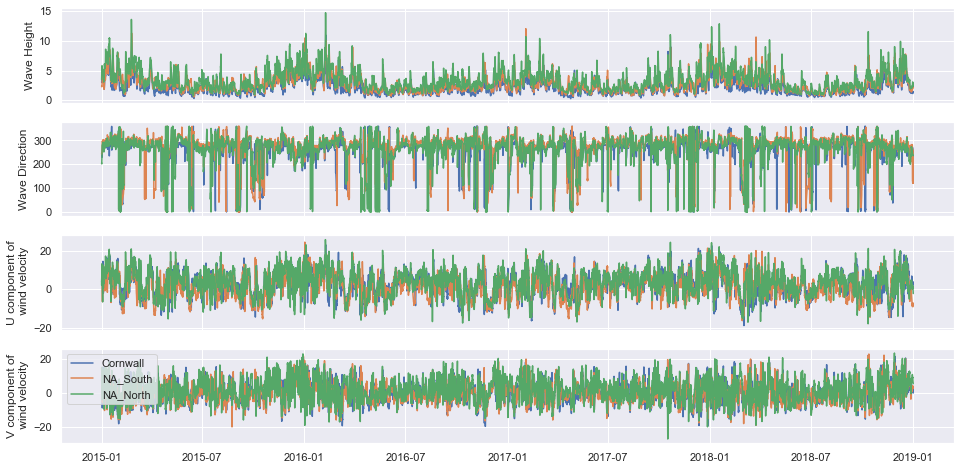

In [5]:
# Plot the time series

sns.set()
f, axes = plt.subplots(4, 1, figsize=(16, 8), sharex=True)

axes[0].plot(df_data.index, df_data['hs_Cornwall'])
axes[0].plot(df_data.index, df_data['hs_South'])
axes[0].plot(df_data.index, df_data['hs_West'])
axes[0].set_ylabel('Wave Height')

axes[1].plot(df_data.index, df_data['dir_Cornwall'])
axes[1].plot(df_data.index, df_data['dir_South'])
axes[1].plot(df_data.index, df_data['dir_West'])
axes[1].set_ylabel('Wave Direction')

axes[2].plot(df_data.index, df_data['u_Cornwall'])
axes[2].plot(df_data.index, df_data['u_South'])
axes[2].plot(df_data.index, df_data['u_West'])
axes[2].set_ylabel('U component of\n wind velocity')

axes[3].plot(df_data.index, df_data['v_Cornwall'], label = 'Cornwall')
axes[3].plot(df_data.index, df_data['v_South'], label = 'NA_South')
axes[3].plot(df_data.index, df_data['v_West'], label = 'NA_North')
axes[3].set_ylabel('V component of\n wind velocity')

plt.legend()



C:\Users\DAW85586\Anaconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


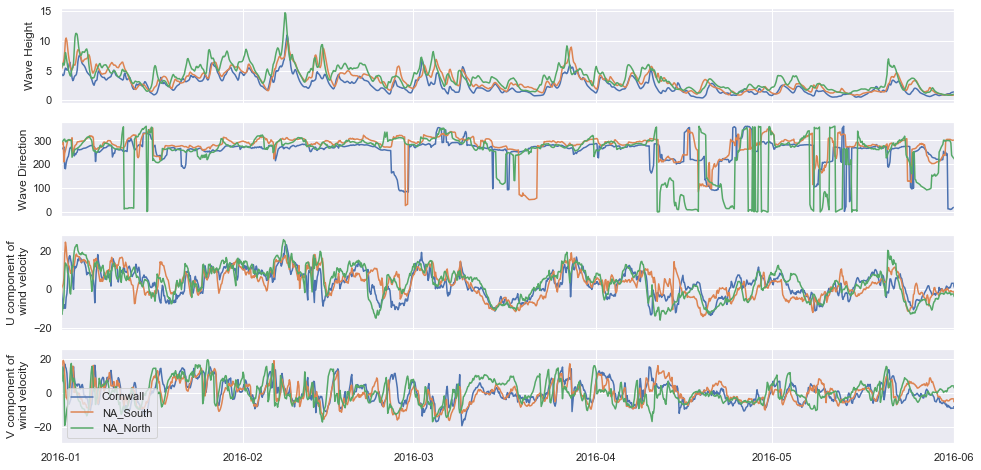

In [6]:
# Plot the time series - zoomed in

sns.set()
f, axes = plt.subplots(4, 1, figsize=(16, 8), sharex=True)

axes[0].plot(df_data.index, df_data['hs_Cornwall'])
axes[0].plot(df_data.index, df_data['hs_South'])
axes[0].plot(df_data.index, df_data['hs_West'])
axes[0].set_ylabel('Wave Height')

axes[1].plot(df_data.index, df_data['dir_Cornwall'])
axes[1].plot(df_data.index, df_data['dir_South'])
axes[1].plot(df_data.index, df_data['dir_West'])
axes[1].set_ylabel('Wave Direction')

axes[2].plot(df_data.index, df_data['u_Cornwall'])
axes[2].plot(df_data.index, df_data['u_South'])
axes[2].plot(df_data.index, df_data['u_West'])
axes[2].set_ylabel('U component of\n wind velocity')

axes[3].plot(df_data.index, df_data['v_Cornwall'], label = 'Cornwall')
axes[3].plot(df_data.index, df_data['v_South'], label = 'NA_South')
axes[3].plot(df_data.index, df_data['v_West'], label = 'NA_North')
axes[3].set_ylabel('V component of\n wind velocity')

plt.legend()

axes[3].set_xlim([datetime.datetime(2016,1,1), datetime.datetime(2016,6,1)])


Now we prepeare the data for analysis, for more details on this see this link:

http://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler_feat = MinMaxScaler(feature_range=(0, 1))
scaled_feat = scaler_feat.fit_transform(df_data[df_data.columns[1:]].values)

scaler_tar = MinMaxScaler(feature_range=(0, 1))
scaled_tar = scaler_tar.fit_transform(df_data[df_data.columns[0]].values.reshape(len(df_data), 1))

In [31]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
lag_steps = 6

reframed_in = series_to_supervised(scaled_feat, lag_steps, 1, dropnan=False)
reframed_in = reframed_in[lag_steps:].reset_index(drop=True)

scaled_tar = scaled_tar[lag_steps:,:]
print(reframed_in.shape, scaled_tar.shape)
reframed_in.head()

(265573, 77) (265573, 1)


var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
0   0.161290   0.194609   0.687415   0.674578   0.572663   0.545017   
1   0.153444   0.217457   0.684775   0.677746   0.561217   0.548098   
2   0.149085   0.253871   0.680690   0.684554   0.566023   0.581273   
3   0.149956   0.290285   0.679829   0.688445   0.587971   0.574875   
4   0.151700   0.334553   0.678328   0.685054   0.618391   0.592411   

   var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...   var2(t)   var3(t)  \
0   0.489158   0.458841   0.713703    0.635712  ...  0.361685  0.651874   
1   0.500141   0.513866   0.715370    0.643386  ...  0.355259  0.669019   
2   0.501117   0.550702   0.715370    0.675241  ...  0.350975  0.688971   
3   0.501117   0.585263   0.749888    0.698725  ...  0.344549  0.711729   
4   0.527477   0.648247   0.776075    0.673846  ...  0.340265  0.747242   

    var4(t)   var5(t)   var6(t)   var7(t)   var8(t)   var9(t)  var10(t)  \
0  0.695726  0.670204  0.710422  0.578488  0.631648  0.758697  0.636875   
1  0.707676  0.740381  0.705446  0.593377  0.653022  0.694420  0.630829   
2  0.768925  0.777886  0.715399  0.588251  0.618460  0.528969  0.616646   
3  0.774483  0.777580  0.624402  0.592888  0.591630  0.356614  0.577350   
4  0.825506  0.778803  0.616819  0.464507  0.525235  0.259009  0.435512   

   var11(t)  
0  0.456528  
1  0.459683  
2  0.483345  
3  0.463824  
4  0.498330  

[5 rows x 77 columns]

In [8]:
sample_split = 0.8

train_X = (reframed_in.values[0:int(sample_split * len(reframed_in.values))])
test_X = (reframed_in.values[int(sample_split * len(reframed_in.values)):])

train_y = (scaled_tar[0:int(sample_split * scaled_tar.shape[0]),:])
test_y = (scaled_tar[int(sample_split * scaled_tar.shape[0]):,:])

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(212458, 1, 77) (212458, 1) (53115, 1, 77) (53115, 1)



Set up and run the neural network, for more details on this see this link:

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

Train on 212458 samples, validate on 53115 samples
Epoch 1/10
 - 10s - loss: 0.0367 - val_loss: 0.0366
Epoch 2/10
 - 12s - loss: 0.0390 - val_loss: 0.0499
Epoch 3/10
 - 10s - loss: 0.0384 - val_loss: 0.0280
Epoch 4/10
 - 10s - loss: 0.0272 - val_loss: 0.0347
Epoch 5/10
 - 10s - loss: 0.0197 - val_loss: 0.0647
Epoch 6/10
 - 14s - loss: 0.0199 - val_loss: 0.0216
Epoch 7/10
 - 9s - loss: 0.0202 - val_loss: 0.0285
Epoch 8/10
 - 9s - loss: 0.0189 - val_loss: 0.0269
Epoch 9/10
 - 9s - loss: 0.0172 - val_loss: 0.0243
Epoch 10/10
 - 10s - loss: 0.0171 - val_loss: 0.0223


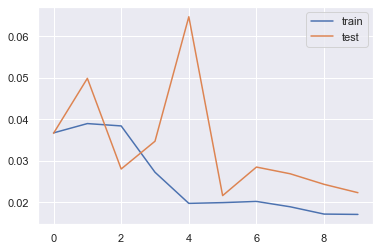

In [33]:
from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM

# Design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), recurrent_dropout=0.1))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Fit network
history = model.fit(
    train_X,
    train_y,
    epochs=10,
    batch_size=72,
    validation_data=(test_X, test_y),
    verbose=2,
    shuffle=False
)

# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:
yhat = model.predict(test_X)
xhat = model.predict(train_X)

In [25]:
inv_yhat = scaler_tar.inverse_transform(yhat)
inv_y = scaler_tar.inverse_transform(test_y)

inv_xhat = scaler_tar.inverse_transform(xhat)
inv_x = scaler_tar.inverse_transform(train_y)

C:\Users\DAW85586\Anaconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


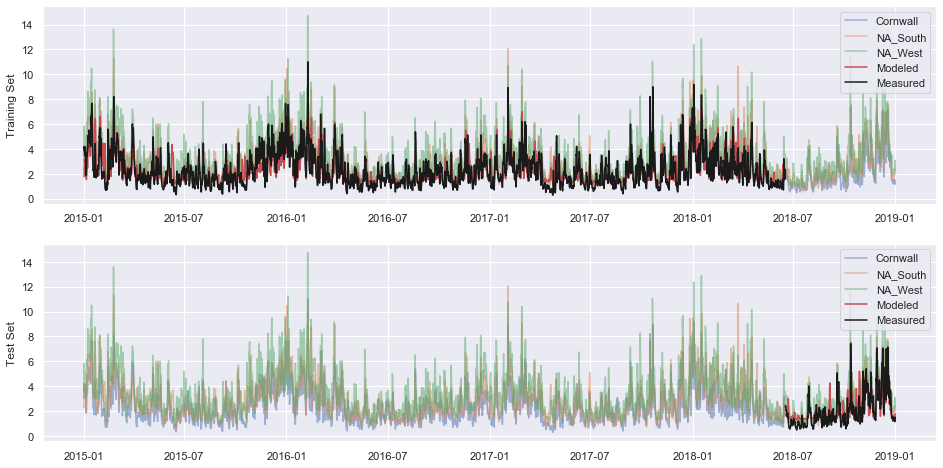

In [26]:
# Plot the predicted time series

dates = df_data.index[lag_steps:]

train_dates = dates[0:int(sample_split * scaled_tar.shape[0])]
test_dates = dates[int(sample_split * scaled_tar.shape[0]):]

sns.set()
fig, axs = plt.subplots(2, figsize=(16, 8))

axs[0].plot(df_data.index,df_data['hs_Cornwall'], label = 'Cornwall', alpha = 0.5)
axs[0].plot(df_data.index,df_data['hs_South'], label = 'NA_South', alpha = 0.5)
axs[0].plot(df_data.index,df_data['hs_West'], label = 'NA_West', alpha = 0.5)

axs[0].plot(train_dates, inv_xhat, label='Modeled', color='r')
axs[0].plot(train_dates, inv_x, label='Measured', color='k')
axs[0].set_ylabel('Training Set')
axs[0].legend()


axs[1].plot(df_data.index,df_data['hs_Cornwall'], label = 'Cornwall', alpha = 0.5)
axs[1].plot(df_data.index,df_data['hs_South'], label = 'NA_South', alpha = 0.5)
axs[1].plot(df_data.index,df_data['hs_West'], label = 'NA_West', alpha = 0.5)

axs[1].plot(test_dates, inv_yhat, label='Modeled', color='r')
axs[1].plot(test_dates, inv_y, label='Measured', color='k')
axs[1].set_ylabel('Test Set')
axs[1].legend()

(736999.0, 737060.0)

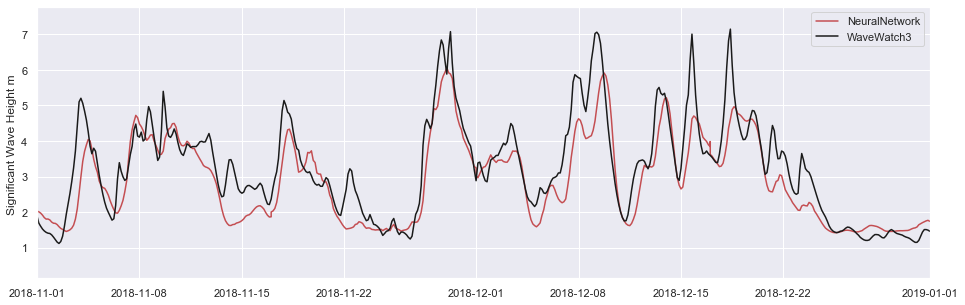

In [39]:
# Take a closer look

fig, axs = plt.subplots(1, figsize=(16, 5))

# axs.plot(df_data.index,df_data['hs_Cornwall'], label = 'Cornwall', alpha = 0.8)
# axs.plot(df_data.index,df_data['hs_South'], label = 'NA_South', alpha = 0.8)
# axs.plot(df_data.index,df_data['hs_West'], label = 'NA_West', alpha = 0.8)

axs.plot(test_dates, inv_yhat, label='NeuralNetwork', color='r')
axs.plot(test_dates, inv_y, label='WaveWatch3', color='k')
axs.set_ylabel('Significant Wave Height m ')
axs.legend()

axs.set_xlim([datetime.datetime(2018,11,1), datetime.datetime(2019,1,1)])
